This notebook demonstrates the end-to-end process of analyzing the dynamical stability of a Neural ODE trained on a Torus, using the theory from Shub and Sullivan (1975).

First, we import the necessary libraries and fix the random seeds to ensure the experiment is reproducible.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import scipy.linalg
import random

# --- Fix random seeds for reproducibility ---
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

Here, we define a concrete dynamical control problem to serve as our testbed.

The system is a 2-degree-of-freedom (2-DOF) planar robot arm. Its state is uniquely defined by its two joint angles, ($\theta_1, \theta_2$). 
Since each angle is a periodic variable in the range $[0,2\pi)$, the natural state space for this system is the 2-Torus, $T^2$.

The task is to train a controller that can generate the correct joint velocities to make the robot's end-effector follow a predefined circular trajectory in its workspace. 
This cell contains the RobotArm class for the forward kinematics and a function generate_trajectory_data to compute the "ground truth" joint angle trajectory corresponding to the target path.

In [2]:
class RobotArm:
    """Defines the kinematics of a 2-DOF robot arm."""
    def __init__(self, l1=1.0, l2=1.0):
        self.l1 = l1
        self.l2 = l2

    def forward_kinematics(self, theta):
        """Forward Kinematics: (theta1, theta2) -> (x, y)"""
        theta1, theta2 = theta[:, 0], theta[:, 1]
        x = self.l1 * torch.cos(theta1) + self.l2 * torch.cos(theta1 + theta2)
        y = self.l1 * torch.sin(theta1) + self.l2 * torch.sin(theta1 + theta2)
        return torch.stack([x, y], dim=1)

def generate_trajectory_data(robot, n_points=200, t_max=2.0):
    """Generates the ground truth trajectory data for the robot arm to draw a circle."""
    t = torch.linspace(0, t_max, n_points)
    # Target trajectory: a circle with center (1, 0) and radius 0.5
    center_x, center_y, radius = 1.0, 0.0, 0.5
    x_target = center_x + radius * torch.cos(2 * np.pi * t / t_max)
    y_target = center_y + radius * torch.sin(2 * np.pi * t / t_max)
    
    # Simplified Inverse Kinematics (IK)
    theta1_truth = torch.atan2(y_target, x_target)
    theta2_truth = torch.acos(torch.clamp((x_target**2 + y_target**2 - robot.l1**2 - robot.l2**2) / (2 * robot.l1 * robot.l2), -1, 1))
    
    # Normalize angles to the [0, 2pi) range
    theta_truth = torch.stack([theta1_truth, theta2_truth], dim=1) % (2 * np.pi)
    return t, theta_truth

This cell defines our learnable `ToroidalODE model` and the `train_model` function, which encapsulates the entire training loop.

To handle the toroidal state space without a dedicated Riemannian optimizer, we employ a practical technique: the optimization is performed in the standard Euclidean space $\mathbb{R}^2$, but the toroidal topology is enforced via the loss function. 
The difference between the predicted and ground truth angles is wrapped to the range $[−
\pi,
\pi]$ using `atan2(sin(diff), cos(diff))`. 
This ensures that the optimizer correctly understands that $0$ and $2\pi$ are the same point, effectively making the flat space "wrap around" into a torus.

In [3]:
class ToroidalODE(nn.Module):
    """A learnable Neural ODE model."""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2) # The final output is a 2D vector representing angular velocities
        )

    def forward(self, t, y):
        # y is a point on the torus; the network computes the velocity vector at y
        return self.net(y)

def train_model(epochs=2001, lr=1e-3):
    """Main function to train the model."""
    print("Starting training (Euclidean approach with modulo)...")
    robot = RobotArm()
    t_gt, theta_gt = generate_trajectory_data(robot)
    
    model = ToroidalODE()
    # Use a standard Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Predict the trajectory generated by the current model using odeint
        theta_pred_unwrapped = odeint(model, theta_gt[0], t_gt)
        
        # To correctly calculate loss in a periodic space, wrap the angle difference to [-pi, pi]
        diff = theta_pred_unwrapped - theta_gt
        loss = ((torch.atan2(torch.sin(diff), torch.cos(diff)))**2).mean()

        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item()}")
            
    print("Training finished.")
    model.eval()
    with torch.no_grad():
        # Get the final predicted trajectory
        theta_pred = odeint(model, theta_gt[0], t_gt)
    
    return model, robot, t_gt, theta_gt, theta_pred

This cell groups all helper functions for post-training evaluation. 
The core run_homological_analysis function implements our proposed diagnostic pipeline:

1. **Generate Basis**: It creates two loops ($\gamma_1, \gamma_2$) that form the basis of the first homology group of the torus.

2. **Propagate**: It uses the trained Neural ODE to compute the transformation of these loops after a unit time interval.

3. **Construct Matrix**: It calculates the winding numbers of the transformed loops to build the integer homology transformation matrix.

4. **Diagnose**: It returns this matrix and its eigenvalues for the final stability analysis.

In [15]:
# --- Analysis Functions ---

def generate_basis_loops(n_points=100):
    """
    Generates the basis loops (gamma1, gamma2) for the 2-Torus.
    These represent the generators of the first homology group H_1(T^2).
    """
    theta = torch.linspace(0, 2 * np.pi, n_points)
    gamma1 = torch.stack([theta, torch.zeros_like(theta)], dim=1)
    gamma2 = torch.stack([torch.zeros_like(theta), theta], dim=1)
    return [gamma1, gamma2]

def run_homological_analysis(model, n_points=100):
    """Computes the homology transformation matrix and its eigenvalues for a trained model."""
    # 1. Generate basis loops using the dedicated function
    basis_loops = generate_basis_loops(n_points)
    
    # 2. Propagate loops through the learned map
    transformed_loops = []
    with torch.no_grad():
        for loop in basis_loops:
            transformed_loops.append(odeint(model, loop, torch.tensor([0.0, 1.0]))[-1])
            
    # 3. Construct homology matrix by calculating winding numbers
    matrix = np.zeros((2, 2), dtype=int)
    for i, loop in enumerate(transformed_loops):
        unwrapped = np.unwrap(loop.numpy(), axis=0)
        windings = (unwrapped[-1] - unwrapped[0]) / (2 * np.pi)
        matrix[:, i] = np.round(windings)
    
    # 4. Return matrix and eigenvalues for diagnosis
    eigenvalues = np.linalg.eigvals(matrix)
    return matrix, eigenvalues

def create_performance_figure(robot, time_gt, theta_gt, theta_pred, filename="figure1_performance.pdf"):
    """
    Figure 1: Visualizes model performance with an improved layout.
    Top panel shows the full trajectory.
    Bottom panel shows four snapshots at different times.
    """
    fig = plt.figure(figsize=(12, 8))
    
    # Define the grid layout: 2 rows, 4 columns
    # Main trajectory plot will span the entire top row
    ax_main = plt.subplot2grid((2, 4), (0, 0), colspan=4)
    # Snapshot plots will occupy the bottom row
    ax1 = plt.subplot2grid((2, 4), (1, 0))
    ax2 = plt.subplot2grid((2, 4), (1, 1))
    ax3 = plt.subplot2grid((2, 4), (1, 2))
    ax4 = plt.subplot2grid((2, 4), (1, 3))
    
    # --- Top Panel: 2D End-Effector Trajectory ---
    gt_path = robot.forward_kinematics(theta_gt).detach().numpy()
    pred_path = robot.forward_kinematics(theta_pred).detach().numpy()
    ax_main.plot(gt_path[:, 0], gt_path[:, 1], 'b:', lw=2, label='Ground Truth Path')
    ax_main.plot(pred_path[:, 0], pred_path[:, 1], 'r-', lw=1.5, label='Predicted Path')
    ax_main.set_title('(a) End-Effector Trajectory Comparison')
    ax_main.set_xlabel('X coordinate')
    ax_main.set_ylabel('Y coordinate')
    ax_main.legend()
    ax_main.set_aspect('equal')
    ax_main.grid(True)

    # --- Bottom Panels: Robot Arm Snapshots ---
    def get_arm_coords(theta_vec):
        """Helper function to get arm linkage coordinates."""
        t1, t2 = theta_vec[0], theta_vec[1]
        x1 = robot.l1 * np.cos(t1); y1 = robot.l1 * np.sin(t1)
        x2 = x1 + robot.l2 * np.cos(t1 + t2); y2 = y1 + robot.l2 * np.sin(t1 + t2)
        return [0, x1, x2], [0, y1, y2]
    
    snapshot_axes = [ax1, ax2, ax3, ax4]
    # Select 4 evenly spaced keyframes
    num_frames = len(time_gt)
    keyframe_indices = [0, num_frames // 3, (2 * num_frames) // 3, num_frames - 1]
    subplot_labels = ['(b)', '(c)', '(d)', '(e)']

    for i, ax in enumerate(snapshot_axes):
        frame_idx = keyframe_indices[i]
        gt_x, gt_y = get_arm_coords(theta_gt[frame_idx].numpy())
        pred_x, pred_y = get_arm_coords(theta_pred[frame_idx].numpy())
        
        ax.plot(gt_x, gt_y, 'bo--', lw=2, markersize=6, alpha=0.8, label='Ground Truth')
        ax.plot(pred_x, pred_y, 'ro-', lw=2, markersize=4, alpha=0.8, label='Predicted')
        
        ax.set_title(f'{subplot_labels[i]} Snapshot at t={time_gt[frame_idx]:.2f}s')
        ax.set_xlim(-2.2, 2.2); ax.set_ylim(-2.2, 2.2)
        ax.set_aspect('equal'); ax.grid(True)
        if i == 0:
            ax.legend()

    plt.tight_layout()
    plt.savefig(filename)
    print(f"Performance figure saved to {filename}")
    plt.close(fig)

def create_homology_figure(model, filename="figure2_homology.pdf"):
    """Figure 2: Visualizes the action of the learned map on the homology basis."""
    # Generate and propagate basis loops
    basis_loops_2d = generate_basis_loops(n_points=100)
    with torch.no_grad():
        transformed_loops_2d = [odeint(model, loop, torch.tensor([0.0, 1.0]))[-1] for loop in basis_loops_2d]

    # Convert to 3D for plotting
    def to_3d(theta_2d, R=2, r=1):
        t1, t2 = theta_2d[:, 0], theta_2d[:, 1]
        x = (R + r * torch.cos(t2)) * torch.cos(t1); y = (R + r * torch.cos(t2)) * torch.sin(t1)
        z = r * torch.sin(t2)
        return torch.stack([x, y, z], dim=1).numpy()
    basis_loops_3d = [to_3d(loop) for loop in basis_loops_2d]
    transformed_loops_3d = [to_3d(loop) for loop in transformed_loops_2d]

    # Create 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the torus surface
    u, v = np.meshgrid(np.linspace(0, 2 * np.pi, 100), np.linspace(0, 2 * np.pi, 50))
    x_surf = (2 + 1 * np.cos(v)) * np.cos(u)
    y_surf = (2 + 1 * np.cos(v)) * np.sin(u)
    z_surf = 1 * np.sin(v)
    ax.plot_surface(x_surf, y_surf, z_surf, color='cyan', alpha=0.2)

    # Plot original and transformed loops
    ax.plot(basis_loops_3d[0][:, 0], basis_loops_3d[0][:, 1], basis_loops_3d[0][:, 2], 'r:', label='Original $\gamma_1$')
    ax.plot(basis_loops_3d[1][:, 0], basis_loops_3d[1][:, 1], basis_loops_3d[1][:, 2], 'b:', label='Original $\gamma_2$')
    ax.plot(transformed_loops_3d[0][:, 0], transformed_loops_3d[0][:, 1], transformed_loops_3d[0][:, 2], 'r-', lw=3, label='Transformed $g(\gamma_1)$', alpha=0.8)
    ax.plot(transformed_loops_3d[1][:, 0], transformed_loops_3d[1][:, 1], transformed_loops_3d[1][:, 2], 'b-', lw=3, label='Transformed $g(\gamma_2)$', alpha=0.8)
    
    ax.set_title('Action of the Learned Map on Homology Basis')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z'); ax.legend()
    
    # Set equal aspect ratio for a natural look
    all_points = np.concatenate(basis_loops_3d + transformed_loops_3d)
    max_val = np.abs(all_points).max()
    ax.set_xlim(-max_val, max_val); ax.set_ylim(-max_val, max_val); ax.set_zlim(-max_val, max_val)
    
    plt.savefig(filename) # Save as PDF
    print(f"Homology figure saved to {filename}")
    plt.close(fig)

This is the main block that runs the full experiment pipeline. It trains the model, visualizes the performance, and finally, runs our stability analysis.

**How to Interpret the Results:**

The final output will show the Homology Matrix and its Eigenvalues.

- The Matrix: Reveals the learned internal strategy of the model (e.g., how it twists or collapses the state space).

- The Eigenvalues: Provide the final diagnosis. If all eigenvalues are roots of unity or zero, the learned system is fundamentally STABLE. Otherwise, it may possess chaotic properties, suggesting potential unreliability despite good performance on the training task.

Starting training (Euclidean approach with modulo)...
Epoch 0 | Loss: 0.48421284556388855
Epoch 500 | Loss: 0.002969658700749278
Epoch 1000 | Loss: 0.0004916803445667028
Epoch 1500 | Loss: 0.00012025518662994727
Epoch 2000 | Loss: 3.0236333259381354e-05
Training finished.


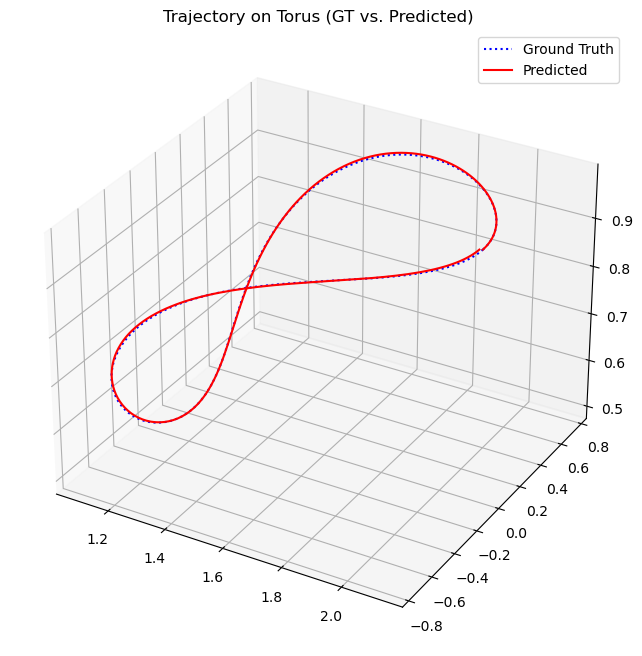

Animation saved to robot_arm_comparison.gif

--- Homological Analysis of Trained Model ---
Homology Matrix:
[[ 1 -1]
 [ 0  0]]
Eigenvalues: [1. 0.]
Diagnosis: The learned control system is STABLE.


In [ ]:
# 1. Train the model
trained_model, arm, time_gt, theta_gt, theta_pred = train_model()


In [16]:

# 2. Generate publication-quality figures
create_performance_figure(arm, time_gt, theta_gt, theta_pred)
create_homology_figure(trained_model)

# 3. Run final analysis and print diagnosis
homology_matrix, eigenvalues = run_homological_analysis(trained_model)
print("\n--- Final Homological Analysis ---")
print(f"Homology Matrix:\n{homology_matrix}")
print(f"Eigenvalues: {eigenvalues}")

# Stability check: eigenvalues must be roots of unity or zero
is_stable = np.all(np.isclose(np.abs(eigenvalues), 1.0) | np.isclose(eigenvalues, 0))
if is_stable:
    print("Diagnosis: The learned control system is STABLE.")
else:
    print("Diagnosis: The learned control system may have CHAOTIC properties.")

Performance figure saved to figure1_performance.pdf
Homology figure saved to figure2_homology.pdf

--- Final Homological Analysis ---
Homology Matrix:
[[ 1 -1]
 [ 0  0]]
Eigenvalues: [1. 0.]
Diagnosis: The learned control system is STABLE.


In [17]:
from matplotlib.animation import FuncAnimation

def create_robot_animation(robot, time_gt, theta_gt, theta_pred, filename="figure3_animation.gif"):
    """
    Figure 3: Creates a GIF animation comparing the ground truth and predicted robot arm movements.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_title('Robot Arm Control: Ground Truth vs. Neural ODE Prediction')
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')

    # Calculate full paths for background plotting
    gt_path = robot.forward_kinematics(theta_gt).detach().numpy()
    pred_path = robot.forward_kinematics(theta_pred).detach().numpy()

    # Plot full trajectories as faint background
    ax.plot(gt_path[:, 0], gt_path[:, 1], 'b:', alpha=0.3, label='Full Ground Truth Path')
    ax.plot(pred_path[:, 0], pred_path[:, 1], 'r:', alpha=0.3, label='Full Predicted Path')

    # Initialize lines for the arms and the current path trace
    gt_arm_line, = ax.plot([], [], 'bo-', lw=3, markersize=8, label='Ground Truth Arm')
    pred_arm_line, = ax.plot([], [], 'ro-', lw=3, markersize=8, label='Predicted Arm')
    
    time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, verticalalignment='top')
    
    ax.legend(loc='upper right')

    def get_arm_coords(theta_vec):
        """Helper function to get arm linkage coordinates."""
        t1, t2 = theta_vec[0], theta_vec[1]
        x1 = robot.l1 * np.cos(t1)
        y1 = robot.l1 * np.sin(t1)
        x2 = x1 + robot.l2 * np.cos(t1 + t2)
        y2 = y1 + robot.l2 * np.sin(t1 + t2)
        return [0, x1, x2], [0, y1, y2]

    def animate(i):
        # Update arm positions
        gt_x, gt_y = get_arm_coords(theta_gt[i].numpy())
        gt_arm_line.set_data(gt_x, gt_y)
        
        pred_x, pred_y = get_arm_coords(theta_pred[i].numpy())
        pred_arm_line.set_data(pred_x, pred_y)
        
        # Update time text
        time_text.set_text(f'Time = {time_gt[i]:.2f}s')
        
        return gt_arm_line, pred_arm_line, time_text

    # Create and save the animation
    ani = FuncAnimation(fig, animate, frames=len(time_gt), interval=50, blit=True)
    ani.save(filename, writer='pillow', fps=20)
    plt.close(fig)
    print(f"Animation figure saved to {filename}")

In [18]:
create_robot_animation(arm, time_gt, theta_gt, theta_pred) # Figure 3 (GIF)

Animation figure saved to figure3_animation.gif
